<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20I%20%3A%20Methods%20%26%20Technologies%20for%20Business%20Analytics/Chapter%207%3A%20Text%20Analytics/7_6_2_Statistical_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Analytics**
##Sentiment Analysis

### Statistical Sentiment Analysis

**1. Sentiment analysis task**

In this notebook, a sentiment analysis example through metal news is explained step by step. Before starting to dataset preparation, Python libraries need to be imported to carry out given classification task.

In [ ]:
# if not previously installed, install nltk for text preprocessing
!pip install nltk
# if not previously installed, install lime for understanding the individual impact of each word
!pip install lime
# if not previously installed, install wordcloud for creating world clouds of each class (spam and ham) 
!pip install wordcloud

     |████████████████████████████████| 275 kB 7.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=5e0344830d522971a3e872f00e7aed34645ebd5d0cd2c2e89c7a7f91e0852dff
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# to process text
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import numpy as np
# to plot
import matplotlib.pyplot as plt
import seaborn as sns
# to prepare dataset
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection,metrics
# for explainer
from lime import lime_text
# to obtain reproducible results
np.random.seed(2)

import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**2. Dataset Preparation**

To classify an SMS message as spam or ham, dataset should be labelled. First, the dataset is read and inspected by 'head' function of pandas to see columns and understanding data types.

In [ ]:
# read the data  
url=   'https://docs.google.com/spreadsheets/d/1XXyxrd7r0mx7kyLaYHDVwh6BFJzo8cPD/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_excel(path)
#df = pd.read_excel('trainingdata16oct2020.xlsx')
df.head()

,summary,sentiment
0,News : METALS-Nickel jumps on talks of Indones...,1
1,News : METALS-Shanghai copper hits near 2-week...,1
2,News : METALS-Copper at near 2-week highs on h...,0
3,News : China's Yunnan to help firms stockpile ...,1
4,News : RPT-UPDATE 1-China turns net aluminium ...,1


The news is given in summary column and corresponding sentiment index given in sentiment column. Sentiment representations are:
*  1 -> positive
*  0 -> neutral
* -1 -> negative

We can also change the column names as 'text' and 'sentiment'.

In [ ]:
df.columns = ['text', 'sentiment']
print(df.head())
df.shape

                                                text  sentiment
0  News : METALS-Nickel jumps on talks of Indones...          1
1  News : METALS-Shanghai copper hits near 2-week...          1
2  News : METALS-Copper at near 2-week highs on h...          0
3  News : China's Yunnan to help firms stockpile ...          1
4  News : RPT-UPDATE 1-China turns net aluminium ...          1


(1120, 2)

We can analyze the sentiment distribution over dataset and understand potential biases of our model in advance. Since our dataset includes considerably small number of neutral news, we should expect less accurate predictions for '0' labelled news.

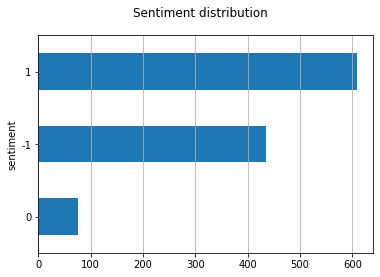

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Sentiment distribution", fontsize=12)
df["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Visuals could be helpful to understand the distribution of classes within the dataset. Also, word clouds leads to have intitution about which words are more attrituble to positive and negative sentiments.

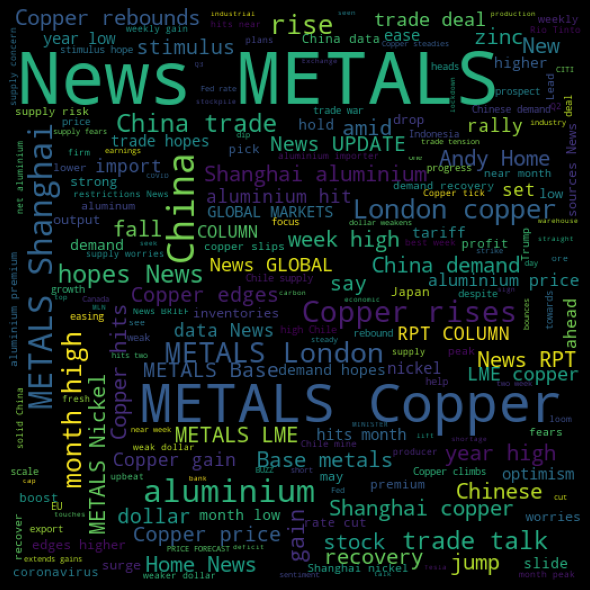

In [ ]:
from wordcloud import WordCloud
pos_words = ' '.join(list(df[df['sentiment'] == 1]['text']))
pos_wc = WordCloud(width = 512,height = 512).generate(pos_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(pos_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


Words similar to 'hopes', 'high', 'recovery' and 'rises' have more positive effect on sentiment as seen above. 

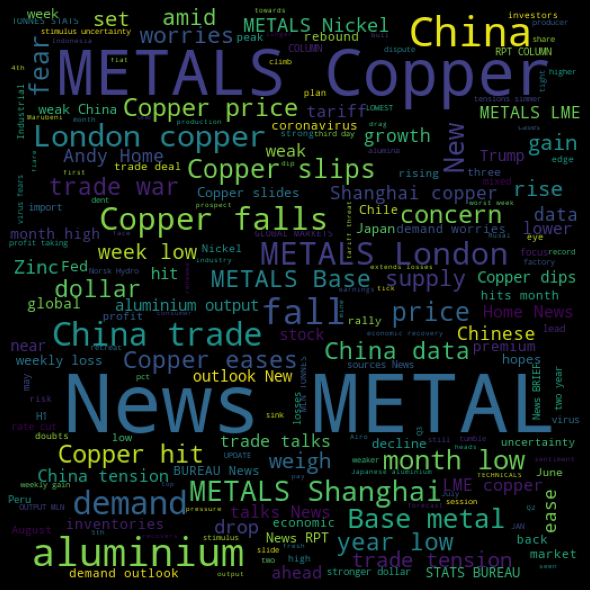

In [ ]:
negative_words = ' '.join(list(df[df['sentiment'] == -1]['text']))
negative_wc = WordCloud(width = 512,height = 512).generate(negative_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(negative_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Compared to positive news, negative news consist 'weak', 'fear', 'decline', 'trade war' and 'tension' terms more frequently.

**3. Text preprocessing**

Second step is processing to text for prepare it to a machine learning model. To understand the individual effect of words on classes, it is needed to work on their most raw versions such as without -ing, -ed or excluding preprositions and stop words. Following function, first converts all letters to lower ones. Then process the each word regarding assigned preferences. In default, it removes stop words, apply stemming and lemmatisation. Finally, it returns preprocessed text.

It is the same function we used in text classification.

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # back to string from list
    text = " ".join(lst_text)
    return text


In [ ]:
# the news are in English language, so nltk english stop words
# are leveraged
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

df.dropna()
df.head()

,text,sentiment,text_clean
0,News : METALS-Nickel jumps on talks of Indones...,1,news metalsnickel jump talk indonesia export ban
1,News : METALS-Shanghai copper hits near 2-week...,1,news metalsshanghai copper hit near 2week high...
2,News : METALS-Copper at near 2-week highs on h...,0,news metalscopp near 2week high hope china imp...
3,News : China's Yunnan to help firms stockpile ...,1,news china yunnan help firm stockpil 110000 to...
4,News : RPT-UPDATE 1-China turns net aluminium ...,1,news rptupdat 1china turn net aluminium import...


In [ ]:
"""Example news from the dataset to understand text processing"""

x="""Kazakhstan's Jan-Aug copper output up; zinc, steel production falls"""
utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords)

'kazakhstan janaug copper output zinc steel product fall'

We generate train and test datasets by splitting 20% of dataset to use in test. 

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.10, random_state=np.random.randint(10,100),shuffle=True)

We can take the train dataset to examine the data in this section.

In [ ]:
train_df

,text,sentiment,text_clean
831,News : METALS-Copper slips to 1-month low as U...,-1,news metalscopp slip 1month low u dollar firm
1078,News : METALS-U.S.-China trade hopes lift base...,1,news metalsuschina trade hope lift base metal ...
273,News : METALS-Copper slips as rattled investor...,1,news metalscopp slip rattl investor await trum...
1016,News : BUZZ-HK-listed Rusal falls after H1 los...,-1,news buzzhklist rusal fall h1 loss forecast so...
894,"News : METALS-Copper rises as U.S., China agre...",1,news metalscopp rise u china agre hold trade talk
...,...,...,...
1117,"News : RPT-COLUMN-New contracts, new platform ...",1,news rptcolumnnew contract new platform lme jo...
229,News : METALS-Shanghai copper falls to 3-week ...,-1,news metalsshanghai copper fall 3week low new ...
70,News : METALS-London copper edges up ahead of ...,1,news metalslondon copper edg ahead fed rate decis
132,"News : METALS-Zinc hits 1-1/2 month low, other...",1,news metalszinc hit 112 month low other recov ...


Now, the text is ready to produce descriptive features. As described in the book, there are several ways to do it. Count vectorizer and TF-IDF implementations are placed below. 

To select meaningful features, 0.95 p-limit is applied with Chi-square statistical feature selection method. We applied 0.99 in previous spam classification example. However, in this context we can not catch features with 0.99 limit since most of them are not so strongly related with the sentiment. Thus, we decrease the p-limit. 

In [ ]:
vectorizer_name = 'CountVectorizer'
if vectorizer_name == 'CountVectorizer':
    vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

elif vectorizer_name == 'Tf-Idf': #(advanced variant of BoW)
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

corpus = train_df["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

y = train_df["sentiment"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.90
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "p-score":1-p, "label":cat}))
    df_features = df_features.sort_values(["label","p-score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["p-score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()

vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


Top features of each class can be seen below.

In [ ]:
for cat in np.unique(test_df.sentiment.values):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(df_features[df_features["label"]==cat]))
    print("  . top features:", ",".join(df_features[df_features["label"]==cat]["feature"].values[:10]))
    print(" ")

# -1:
  . selected features: 649
  . top features: fall,high,metalscopp fall,news metalscopp fall,hope,rise,tension,low,viru,loss
 
# 0:
  . selected features: 914
  . top features: commod,arrow,arrow china,arrow china commod,begin,china commod,china commod exposur,commod exposur,commod exposur russel,disrupt fear
 
# 1:
  . selected features: 349
  . top features: high,hope,rise,fall,metalscopp fall,news metalscopp fall,tension,metalscopp rise,news metalscopp rise,viru
 


**4. Model Training**

After selecting features, they could be supplied to a machine learning classifier. There are several classifier algorithms and most of them are suitable and have considerably high performance with the text classification tasks such as in sentiment analysis with labelled data. Following function initialize selected model and produce prediction for classes. It utilizes given vectorizer and machine learning algorithm. At the end of validation, it gives accuracy, precision and recall metrics to compare performance of different classifiers.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def predict(X_train, y_train, y_test, classifier=MLPClassifier(alpha=1, max_iter=50), name="Neural Net"):
    
    print('---------------Prediction with '+name+ '---------------------------')
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
    model["classifier"].fit(X_train, y_train)
    ## test
    X_test = test_df["text_clean"].values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,3))
    print("Auc:", round(auc,3))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.3f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic: \n" + name)
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.3f})'.format(classes[i], metrics.auc(recall, precision)))
    
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve:\n " + name)
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return predicted, predicted_prob, model

---------------Prediction with Nearest Neighbors---------------------------
Accuracy: 0.643
Auc: 0.679
Detail:
              precision    recall  f1-score   support

          -1       0.65      0.55      0.60        47
           0       0.00      0.00      0.00        10
           1       0.64      0.84      0.72        55

    accuracy                           0.64       112
   macro avg       0.43      0.46      0.44       112
weighted avg       0.59      0.64      0.61       112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


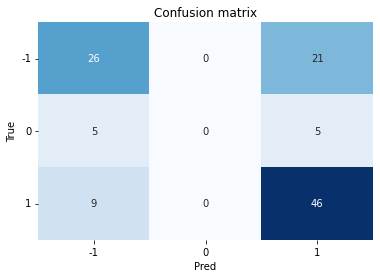

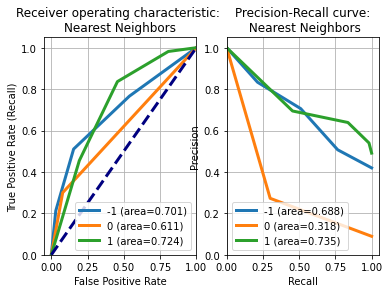

---------------Prediction with Decision Tree---------------------------
Accuracy: 0.536
Auc: 0.663
Detail:
              precision    recall  f1-score   support

          -1       0.47      0.72      0.57        47
           0       0.00      0.00      0.00        10
           1       0.65      0.47      0.55        55

    accuracy                           0.54       112
   macro avg       0.37      0.40      0.37       112
weighted avg       0.52      0.54      0.51       112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


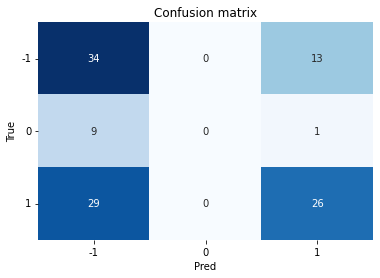

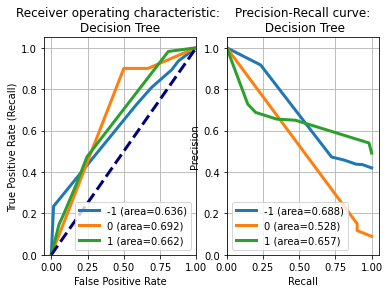

---------------Prediction with Random Forest---------------------------
Accuracy: 0.5
Auc: 0.596
Detail:
              precision    recall  f1-score   support

          -1       1.00      0.02      0.04        47
           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.66        55

    accuracy                           0.50       112
   macro avg       0.50      0.34      0.23       112
weighted avg       0.66      0.50      0.34       112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


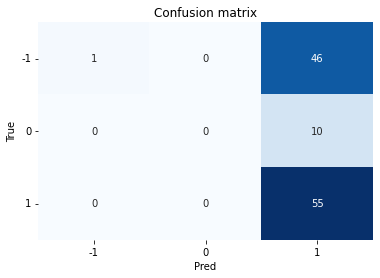

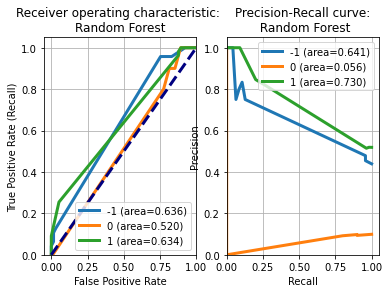

---------------Prediction with Neural Net---------------------------
Accuracy: 0.679
Auc: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.77      0.51      0.62        47
           0       0.00      0.00      0.00        10
           1       0.64      0.95      0.76        55

    accuracy                           0.68       112
   macro avg       0.47      0.49      0.46       112
weighted avg       0.64      0.68      0.63       112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


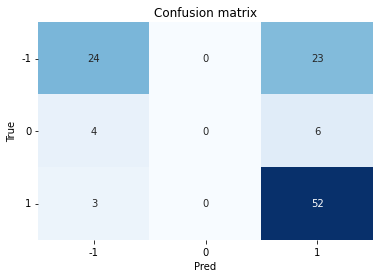

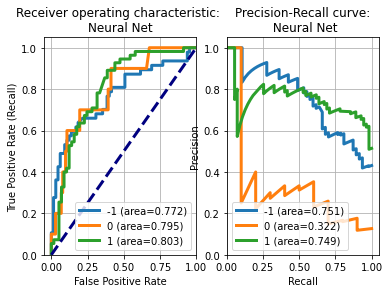

---------------Prediction with AdaBoost---------------------------
Accuracy: 0.562
Auc: 0.586
Detail:
              precision    recall  f1-score   support

          -1       0.57      0.45      0.50        47
           0       0.25      0.10      0.14        10
           1       0.58      0.75      0.65        55

    accuracy                           0.56       112
   macro avg       0.47      0.43      0.43       112
weighted avg       0.54      0.56      0.54       112



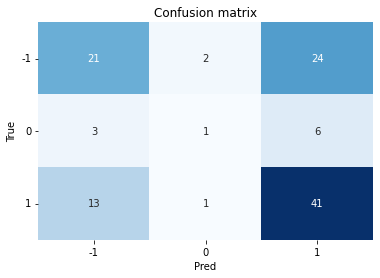

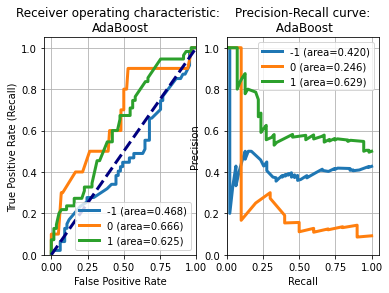

---------------Prediction with Naive Bayes---------------------------
Accuracy: 0.598
Auc: 0.746
Detail:
              precision    recall  f1-score   support

          -1       0.73      0.34      0.46        47
           0       0.00      0.00      0.00        10
           1       0.57      0.93      0.70        55

    accuracy                           0.60       112
   macro avg       0.43      0.42      0.39       112
weighted avg       0.58      0.60      0.54       112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


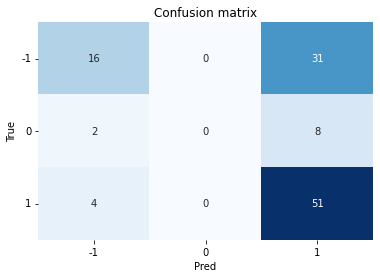

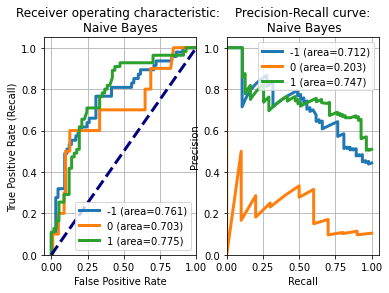

In [ ]:
df_classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    naive_bayes.MultinomialNB()]

names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

# train classifier
for name, classifier in zip(names, df_classifiers):
    predict(X_train, y_train, y_test, classifier, name)

The best performed model is the Neural Network algorithm with a 68% accuracy. This accuracy is lower than we achieve in spam classification task, which was 97%.  Since sentiment analysis is more complex task than spam classifictaion, more complex models could help to resolve this problem. Please check deep learning based methods notebooks for further information.
It is possible to check the trained model with individual sample and observe the effect of text processing and feature selection through 'Lime'.

---------------Prediction with Neural Net---------------------------
Accuracy: 0.634
Auc: 0.774
Detail:
              precision    recall  f1-score   support

          -1       0.82      0.38      0.52        47
           0       0.00      0.00      0.00        10
           1       0.59      0.96      0.73        55

    accuracy                           0.63       112
   macro avg       0.47      0.45      0.42       112
weighted avg       0.63      0.63      0.58       112



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


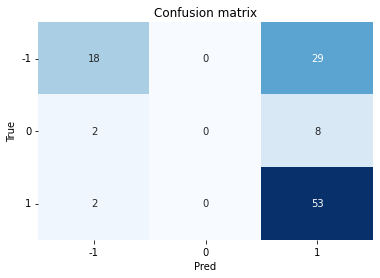

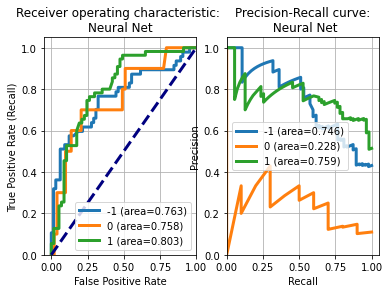

True: 1 --> Pred: 1 | Prob: 0.84


In [ ]:
predicted, predicted_prob, model = predict(X_train, y_train, y_test)
## select observation
i = 100
txt_instance = test_df["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=10)
explained.show_in_notebook(text=txt_instance, predict_proba=False)